**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Listeria-infected vs uninfected matched explants (day1) single cell

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [3]:
anndata <- readRDS('../../../../data_integration/48h/results/scVI/listeria_singleCell_48h.rds')
anndata

An object of class Seurat 
36601 features across 18752 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [4]:
Idents(anndata)= anndata$cell_type

In [5]:
head(Idents(anndata))

Pla_HDBR12330714_AAACCCATCCACGAAT Pla_HDBR12330714_AAACCCATCGAGTCTA 
                              HBC                             PAMM1 
Pla_HDBR12330714_AAACCCATCGATAACC Pla_HDBR12330714_AAACCCATCGCACGAC 
                               PV                                PV 
Pla_HDBR12330714_AAACGAATCTAGATCG Pla_HDBR12330714_AAACGCTCATACCATG 
                           Endo_f                             PAMM1 
14 Levels: EVT_1 EVT_2 Endo_f F F_p HBC HBC_p PAMM1 PV VCT ... iEVT

# Fibroblasts and Endo_f

In [6]:
fibroEndo= subset(x = anndata, idents = c('F','PV','Endo_f'))

Idents(object = fibroEndo) <- "infection"


#fixing levels
fibroEndo$celltype.Stage = factor(fibroEndo$celltype.Stage, levels = c("F-Lm_48h", "F-UI_Lm_48h", "PV-Lm_48h","PV-UI_Lm_48h", "Endo_f-Lm_48h","Endo_f-UI_Lm_48h"))
fibroEndo$cell_type<- factor(fibroEndo$cell_type, levels = c("F","PV","Endo_f"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
fibroEndo$infection<- factor(fibroEndo$infection, levels = c("UI","Lm"))

In [7]:
fibroEndo$classification = paste(fibroEndo$cell_type, fibroEndo$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = fibroEndo, features = rownames(fibroEndo), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [8]:
head(percent_mat)

,Endo_f-Lm,Endo_f-UI,F-Lm,F-UI,PV-Lm,PV-UI
AC115284.3,0.03623188,0.00000000,0.2272727,0.1531394,0.07722008,0.2932551
RNF186,0.00000000,0.05707763,0.0000000,0.0000000,0.00000000,0.0000000
FMR1,37.97101449,37.21461187,34.4318182,36.9065850,32.04633205,32.3558162
CANX,97.75362319,97.14611872,98.6363636,99.6937213,97.29729730,96.9696970
ZNF84-DT,0.07246377,0.22831050,0.0000000,0.3062787,0.00000000,0.6842620
LIPA,63.15217391,63.35616438,27.3863636,32.4655436,37.68339768,44.2815249


In [9]:
#print(Idents(VCT_fusing))

In [10]:
table(fibroEndo[["celltype.Stage"]] )


        F-Lm_48h      F-UI_Lm_48h        PV-Lm_48h     PV-UI_Lm_48h 
             880              653             1295             1023 
   Endo_f-Lm_48h Endo_f-UI_Lm_48h 
            2760             1752 

In [11]:
anndata_sce <- as.SingleCellExperiment(fibroEndo)

In [12]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 8363 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(8363): Pla_HDBR12330714_AAACCCATCGATAACC
  Pla_HDBR12330714_AAACCCATCGCACGAC ...
  Pla_HDBR13661576_TTTGTTGCATCCCGTT Pla_HDBR13661576_TTTGTTGTCAGCTGAT
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [13]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Lm-Endo_f-Hrv136-1,Lm-Endo_f-Hrv136-2,Lm-Endo_f-Hrv136-3,Lm-Endo_f-Hrv236-1,Lm-Endo_f-Hrv236-2,Lm-Endo_f-Hrv236-3,Lm-F-Hrv136-1,Lm-F-Hrv136-2,Lm-F-Hrv136-3,Lm-F-Hrv236-1,⋯,UI-F-Hrv136-3,UI-F-Hrv236-1,UI-F-Hrv236-2,UI-F-Hrv236-3,UI-PV-Hrv136-1,UI-PV-Hrv136-2,UI-PV-Hrv136-3,UI-PV-Hrv236-1,UI-PV-Hrv236-2,UI-PV-Hrv236-3
AC115284.3,0,0,0,0,1,0,0,0,0,0,⋯,0,1,0,0,0,1,0,0,2,0
RNF186,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FMR1,51,36,58,485,427,451,96,77,82,43,⋯,72,39,34,46,57,71,42,107,110,85



Endo_f-Lm Endo_f-UI      F-Lm      F-UI     PV-Lm     PV-UI 
        6         6         6         6         6         6 


UI Lm 
18 18 

In [14]:
summed

class: SingleCellExperiment 
dim: 36601 36 
metadata(0):
assays(1): counts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(36): Lm-Endo_f-Hrv136-1 Lm-Endo_f-Hrv136-2 ... UI-PV-Hrv236-2
  UI-PV-Hrv236-3
colData names(15): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [15]:
summed$infection<- factor(summed$infection, levels = c( "UI","Lm"))

In [16]:
table(summed$infection)


UI Lm 
18 18 

### Corrected by genotype

In [17]:
DEGs_list = list()

In [18]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "Endo_f"
[1] "F"
[1] "PV"


In [21]:
##  Saving the DEG matrix

write.table(DEGs_list[["F"]],'../results/SC_limma_fibroEndo_LIS_48h/1_DEGs_SC_LIS_48h_F.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["PV"]],'../results/SC_limma_fibroEndo_LIS_48h/2_DEGs_SC_LIS_48h_PV.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["Endo_f"]],'../results/SC_limma_fibroEndo_LIS_48h/3_DEGs_SC_LIS_48h_Endof.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)

In [ ]:
#colData(summed_celltype)$metacell_id

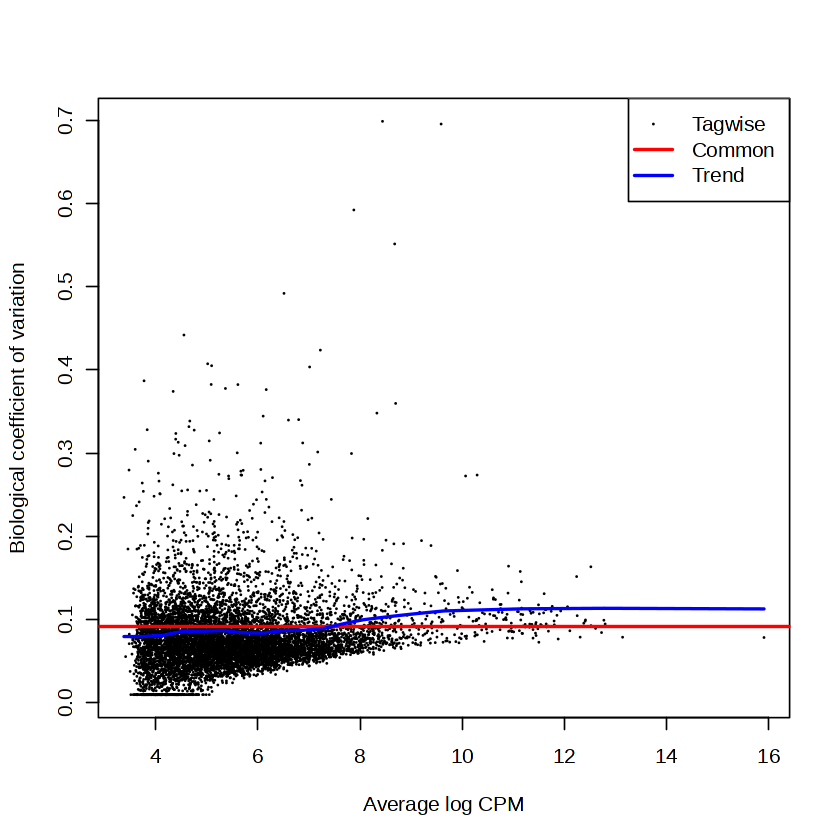

In [22]:
plotBCV(y)

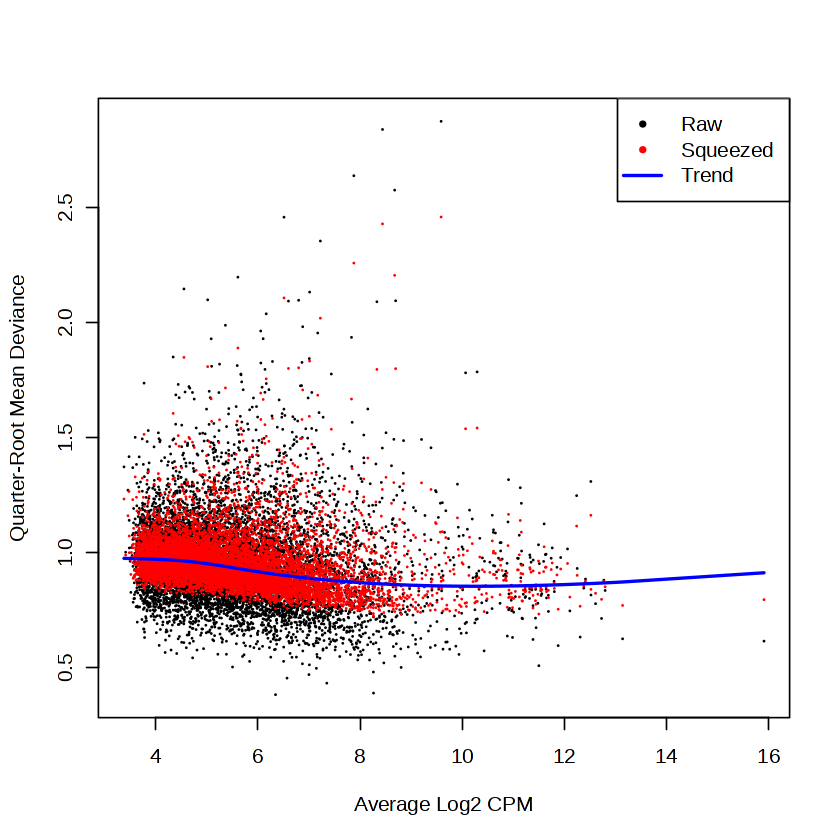

In [23]:
plotQLDisp(fit)

In [24]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Lm-PV-Hrv136-1,Lm-PV-Hrv136-2,Lm-PV-Hrv136-3,Lm-PV-Hrv236-1,Lm-PV-Hrv236-2,Lm-PV-Hrv236-3,UI-PV-Hrv136-1,UI-PV-Hrv136-2,UI-PV-Hrv136-3,UI-PV-Hrv236-1,UI-PV-Hrv236-2,UI-PV-Hrv236-3
FRMD3,26.472947,32.416621,34.244644,50.69952,51.20216,47.00663,61.75079,73.16022,64.090775,121.44274,128.39804,135.25668
LIF,147.767176,177.768566,126.556291,114.34693,126.90032,114.40937,51.55892,62.93931,56.903025,49.31194,41.70753,55.14930
TBX5,45.725999,47.056385,54.592910,54.28749,53.22814,47.80336,97.12261,96.29176,91.643819,105.39218,97.17199,89.96984
PTN,38.024778,28.756680,30.770549,16.84784,11.97173,17.52790,89.32882,102.74708,100.628507,37.12899,34.06479,35.02182
CEBPB,367.251971,376.973929,327.557460,335.55285,357.67840,359.64058,222.42276,202.80444,218.028432,161.85919,150.45280,177.92694
PLA2G5,62.091093,53.853418,52.111414,135.09473,143.29238,126.67889,99.52070,95.75382,89.247902,233.40985,211.59473,233.27752
LHFPL6,330.671171,402.593516,448.158161,586.55450,535.22834,586.70653,896.28579,870.39147,900.864729,941.76135,1027.83940,970.74846
HBEGF,135.734018,110.843929,122.089599,86.11119,71.64619,70.11159,47.96178,48.41485,57.502004,32.48787,36.68515,45.89066
AGPAT4,144.879218,151.626129,142.437865,84.86320,79.01341,73.29848,73.74124,90.37439,90.445860,47.37814,47.82172,50.72125
IER3,1701.969814,1872.321274,1586.172185,1089.33779,1255.37382,1135.01102,1107.31763,1013.48426,855.941289,599.86524,557.92005,696.20960


In [25]:
summary(decideTests(qlf))

       summed_celltype$infectionLm
Down                          1072
NotSig                        6165
Up                            1123

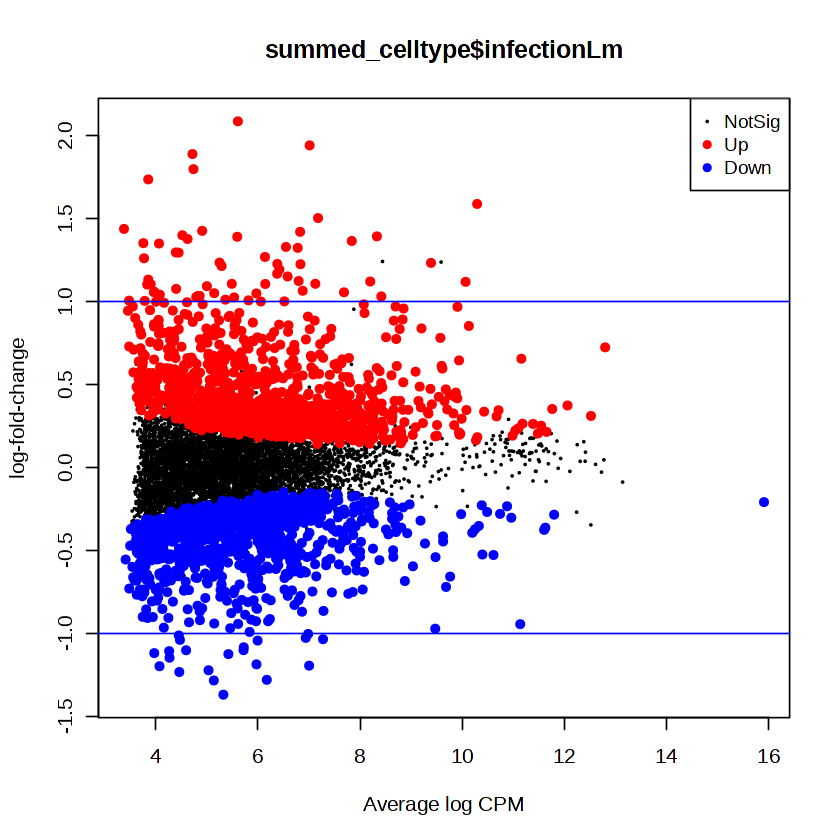

In [26]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

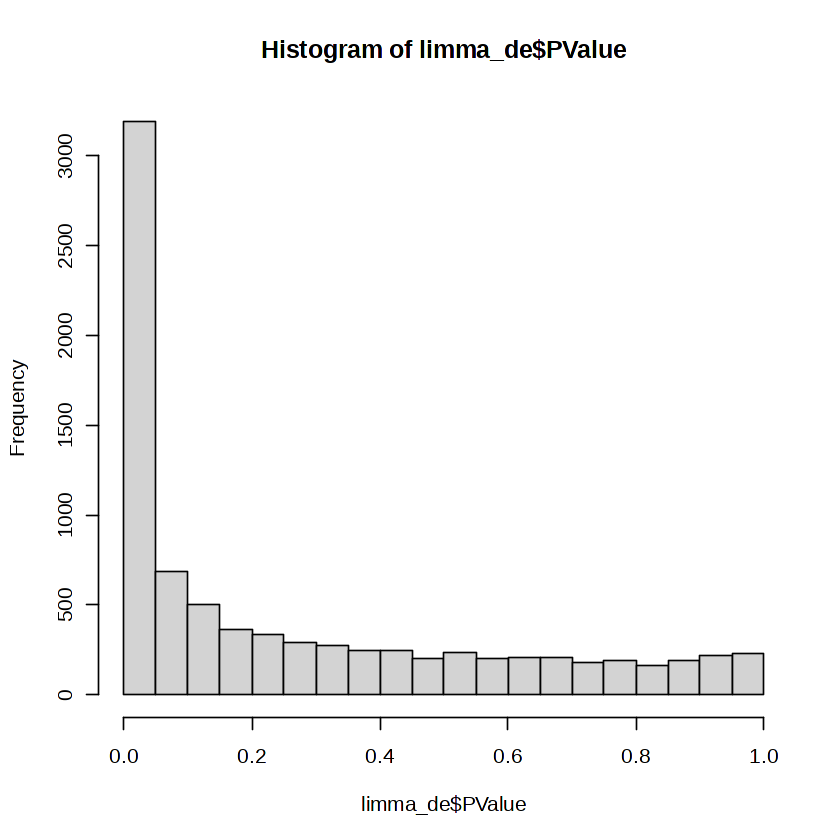

In [27]:
limma_de = qlf$table
limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

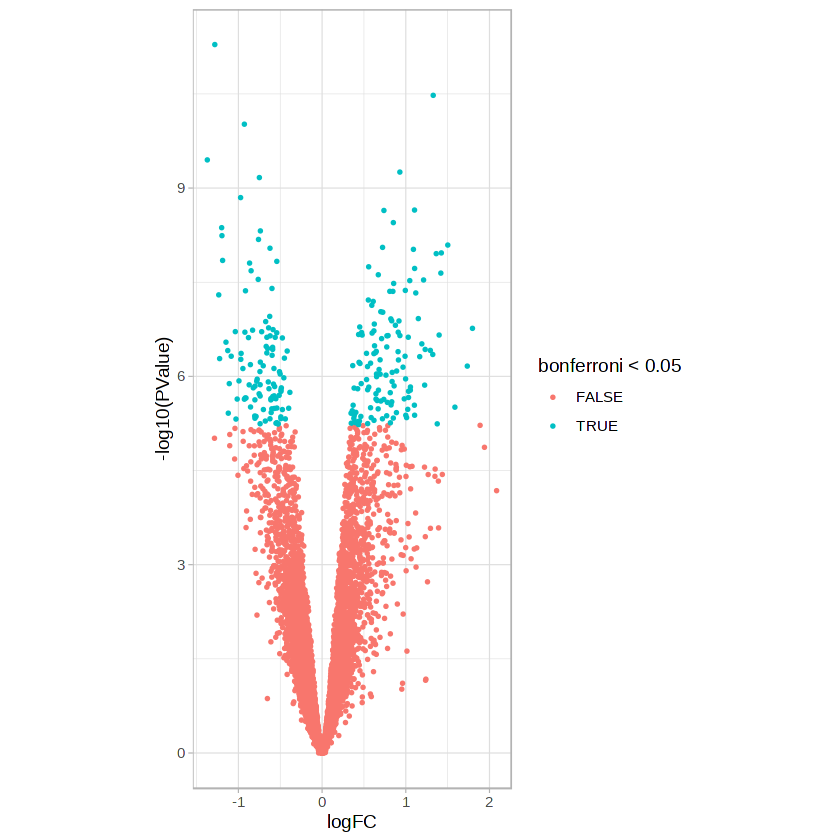

In [28]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = bonferroni < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

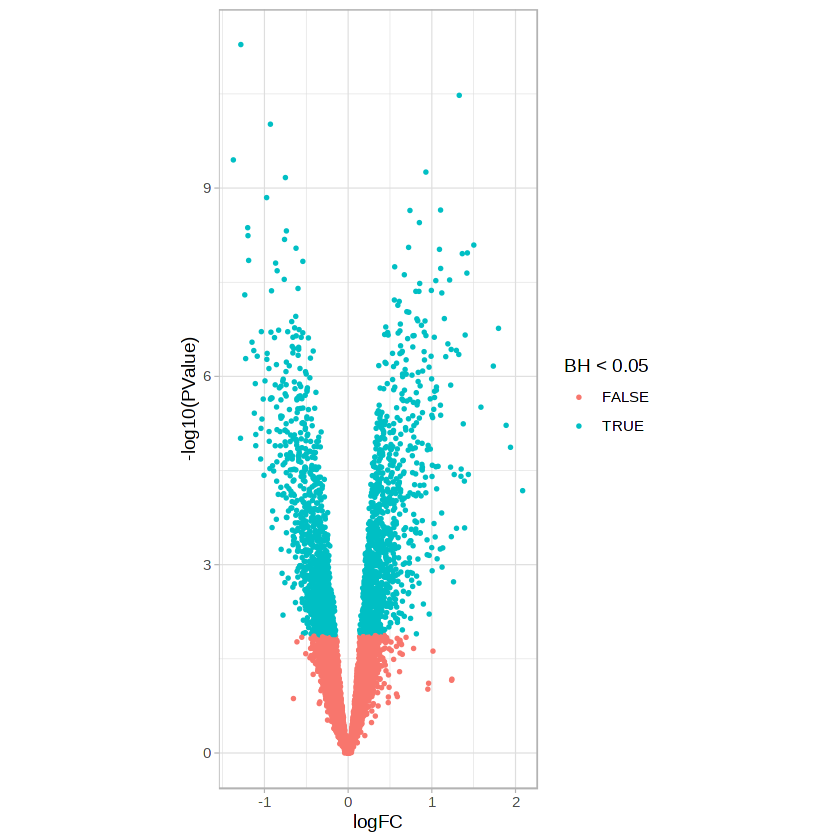

In [29]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
